In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, signal
import cv2
import seaborn as sns
import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Activation
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from IPython.display import clear_output

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
DATA_DIR='C:\g_images\downloads\originals'
CLASSES = ['cats','dogs','panda','bikes','horse']

In [ ]:
training_data=[] #list
training_label=[]

img_resize = 100

def self_generated_train_data():
    for c in CLASSES:
        path = os.path.join(DATA_DIR,c)
        class_no = CLASSES.index(c)
        for img in os.listdir(path):
            #try:
            #print(os.path.join(path,img))
            img_array_bgr = cv2.imread(os.path.join(path,img))
            rgb_img = cv2.cvtColor(img_array_bgr, cv2.COLOR_BGR2RGB)
            rgb_image_resized = cv2.resize(rgb_img,(img_resize,img_resize))
            training_data.append(rgb_image_resized) #append array to a list
            training_label.append(class_no)
            #except:
            #    print(os.path.join(path,img)) # this will show the name of file if any error while loading any image
            break    
        print("Class %d loaded: %s "%(class_no,c))

In [ ]:
self_generated_train_data()

In [ ]:
# Convert into an array for model input
training_data = np.array(training_data)
training_label = np.array(training_label)

In [ ]:
print("Training data shape:",training_data.shape)
print("Training label shape:",training_label.shape)

In [ ]:
# save the resized data to prevent from re-loading from scratch 

pickle_out=open("training_data_100px.pickle",'wb')
pickle.dump(training_data,pickle_out)
pickle_out.close()

pickle_out=open("training_data_100px.pickle",'wb')
pickle.dump(training_label,pickle_out)
pickle_out.close()

In [3]:
# to load the resized data
pickle_in = open("training_data_100px.pickle",'rb')
training_data = pickle.load(pickle_in)

pickle_in = open("training_label_100px.pickle",'rb')
training_label = pickle.load(pickle_in)

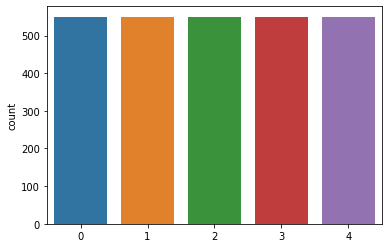

In [4]:
sns.countplot(training_label)

In [5]:
Class_label_counters = {label:list(training_label).count(label) for label in list(training_label)}
print('Class counts:',Class_label_counters)

Class counts: {0: 550, 1: 550, 2: 550, 3: 550, 4: 550}


In [6]:
total_classes = len(np.unique(training_label))
print('Total Number of classes:',total_classes)

Total Number of classes: 5


In [7]:
y_categorical = to_categorical(training_label,total_classes)

In [8]:
# Normalize the data 
training_data = training_data.astype('float32') / 255.

In [9]:
#shuffle the dataset
x_shuffle,y_shuffle = shuffle(training_data,y_categorical)

In [10]:
X, X_test, Y, Y_test = train_test_split(x_shuffle,y_shuffle,test_size = 0.10)

In [11]:
X_train,X_valid,Y_train,Y_valid = train_test_split(X,Y,test_size = 0.20)

In [12]:
print("Test data shape after split:",X_test.shape)

Test data shape after split: (275, 100, 100, 3)


In [13]:
print("Training data shape after split:",X_train.shape)
print("Validation data shape after split:",X_valid.shape)

Training data shape after split: (1980, 100, 100, 3)
Validation data shape after split: (495, 100, 100, 3)


In [14]:
print("Training label shape after split:",Y_train.shape)
print("Validation label shape after split:",Y_valid.shape)

Training label shape after split: (1980, 5)
Validation label shape after split: (495, 5)


In [15]:
# Hyper-parameters settings
image_size = X_train.shape[1]
input_shape = (image_size, image_size, 3)
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.4

In [16]:
# model is a stack of CNN-ReLU-MaxPooling
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=kernel_size,activation='relu',input_shape=input_shape))
model.add(Conv2D(filters=16,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=16,kernel_size=kernel_size,activation='relu'))
model.add(MaxPooling2D(pool_size))


model.add(Conv2D(filters=32,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=32,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=32,kernel_size=kernel_size,activation='relu'))
model.add(MaxPooling2D(pool_size))
#model.add(Dropout(dropout))

model.add(Conv2D(filters=64,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=64,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=64,kernel_size=kernel_size,activation='relu'))
model.add(MaxPooling2D(pool_size))
#model.add(Dropout(dropout))


model.add(Conv2D(filters=128,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=128,kernel_size=kernel_size,activation='relu'))
model.add(Conv2D(filters=128,kernel_size=kernel_size,activation='relu'))
model.add(Flatten())
#model.add(Dropout(dropout))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(total_classes)) # output layer is 5-dim one-hot vector
model.add(Activation('softmax'))

W0907 23:48:20.259948 15720 deprecation.py:506] From C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
#plot_model(model, to_file='cnn-wAG.png', show_shapes=True)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 43, 43, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 32)        9

In [19]:
# loss function for one-hot vector encoding
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [20]:
# Training the convnet using data-augmentation generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [21]:
training_batch_size = 64
train_generator = train_datagen.flow(X_train, y = Y_train,batch_size = training_batch_size)
print("Number of Batches",len(train_generator))

Number of Batches 31


In [22]:
#validation_datagen = ImageDataGenerator()

In [23]:
# OR validation dataset can also be augmented only if validation consists of normal data that doesn't matches with training data
validation_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

In [24]:
validation_batch_size = 32
validation_generator = validation_datagen.flow(X_valid,y= Y_valid,batch_size=validation_batch_size)
print("Number of Batches",len(validation_generator))

Number of Batches 16


In [25]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = X_train.shape[0]//training_batch_size,
    epochs = 200,
    validation_data = validation_generator,
    validation_steps = X_valid.shape[0]//validation_batch_size
    )

Epoch 1/200
30/30 [==============================] - 17s 555ms/step - loss: 1.5793 - acc: 0.2307 - val_loss: 1.5069 - val_acc: 0.3042
Epoch 2/200
30/30 [==============================] - 9s 307ms/step - loss: 1.4206 - acc: 0.3340 - val_loss: 1.3636 - val_acc: 0.3271
Epoch 3/200
30/30 [==============================] - 9s 306ms/step - loss: 1.3484 - acc: 0.3591 - val_loss: 1.3175 - val_acc: 0.3792
Epoch 4/200
30/30 [==============================] - 9s 306ms/step - loss: 1.3334 - acc: 0.3591 - val_loss: 1.3006 - val_acc: 0.3562
Epoch 5/200
30/30 [==============================] - 9s 307ms/step - loss: 1.3222 - acc: 0.3479 - val_loss: 1.2638 - val_acc: 0.3917
Epoch 6/200
30/30 [==============================] - 9s 307ms/step - loss: 1.3039 - acc: 0.3781 - val_loss: 1.3061 - val_acc: 0.3750
Epoch 7/200
30/30 [==============================] - 9s 307ms/step - loss: 1.3216 - acc: 0.3651 - val_loss: 1.3134 - val_acc: 0.3979
Epoch 8/200
30/30 [==============================] - 9s 307ms/step -

30/30 [==============================] - 9s 306ms/step - loss: 0.5295 - acc: 0.7808 - val_loss: 0.4909 - val_acc: 0.7833
Epoch 124/200
30/30 [==============================] - 9s 307ms/step - loss: 0.5425 - acc: 0.7704 - val_loss: 0.5123 - val_acc: 0.7646
Epoch 125/200
30/30 [==============================] - 9s 302ms/step - loss: 0.5706 - acc: 0.7479 - val_loss: 0.5338 - val_acc: 0.7521
Epoch 126/200
30/30 [==============================] - 9s 310ms/step - loss: 0.5236 - acc: 0.7693 - val_loss: 0.5742 - val_acc: 0.7417
Epoch 127/200
30/30 [==============================] - 9s 305ms/step - loss: 0.5376 - acc: 0.7661 - val_loss: 0.5452 - val_acc: 0.7792
Epoch 128/200
30/30 [==============================] - 9s 305ms/step - loss: 0.6181 - acc: 0.7432 - val_loss: 0.5630 - val_acc: 0.7312
Epoch 129/200
30/30 [==============================] - 9s 302ms/step - loss: 0.5899 - acc: 0.7578 - val_loss: 0.5500 - val_acc: 0.7750
Epoch 130/200
30/30 [==============================] - 9s 303ms/step 

Epoch 184/200
30/30 [==============================] - 9s 305ms/step - loss: 0.4107 - acc: 0.8455 - val_loss: 0.5330 - val_acc: 0.7958
Epoch 185/200
30/30 [==============================] - 9s 308ms/step - loss: 0.4615 - acc: 0.8205 - val_loss: 0.5057 - val_acc: 0.8062
Epoch 186/200
30/30 [==============================] - 9s 308ms/step - loss: 0.3934 - acc: 0.8413 - val_loss: 0.4117 - val_acc: 0.8333
Epoch 187/200
30/30 [==============================] - 9s 302ms/step - loss: 0.3936 - acc: 0.8460 - val_loss: 0.5051 - val_acc: 0.7542
Epoch 188/200
30/30 [==============================] - 9s 306ms/step - loss: 0.4483 - acc: 0.8126 - val_loss: 0.6446 - val_acc: 0.7688
Epoch 189/200
30/30 [==============================] - 9s 305ms/step - loss: 0.3946 - acc: 0.8429 - val_loss: 0.4398 - val_acc: 0.8146
Epoch 190/200
30/30 [==============================] - 9s 302ms/step - loss: 0.3806 - acc: 0.8450 - val_loss: 0.5934 - val_acc: 0.7750
Epoch 191/200
30/30 [==============================] - 

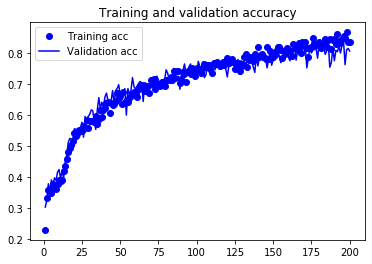

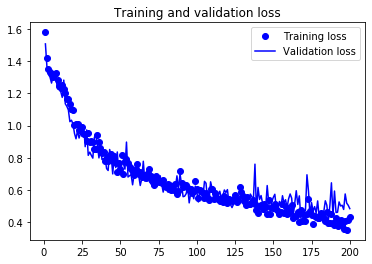

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [31]:
model.save('CNN_wAG.h5')

In [32]:
# del model

In [33]:
test_datagen = ImageDataGenerator()

In [34]:
test_generator = test_datagen.flow(X_test, y = Y_test,
                                   batch_size=1,
                                   shuffle='False')

#Evaluate model on test set
loss,accuracy = model.evaluate_generator(test_generator)
accuracy

0.78909093

In [35]:
test_image, test_labels = next(test_generator)
print('Size of batch:',test_image.shape)

Size of batch: (1, 100, 100, 3)


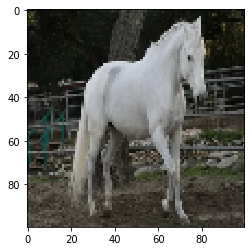

In [36]:
plt.imshow(test_image[0])

#### 1) Code 1: to match the output from evaluate_generator

In [37]:
y_pred=[]
y_true=[]

for i in range(len(X_test)):
    
    test_image, test_label = next(test_generator)
    
    y_pred.append(np.argmax(model.predict(test_image),-1)[0])
    
    y_true.append(np.argmax(test_label,-1)[0])

print(sum(np.array(y_pred)==np.array(y_true))/len(X_test))

0.7890909090909091


In [38]:
# this snippet can be used when the batch size equal to the entire test or validation or training data

#y_img_batch, y_class_batch = test_generator[0] 
#y_pred = np.argmax(model.predict(y_img_batch),-1)
#y_true = np.argmax(y_class_batch,-1)
#print(sum(y_pred==y_true)/len(X_test))

#### 2) Code 2:  to match the output from evaluate_generator

In [39]:
# print(test_generator.index_array)

In [40]:
test_generator.reset()

Y_pred = model.predict_generator(test_generator)

classes = np.argmax(test_generator.y,axis=-1)[test_generator.index_array]

y_pred = np.argmax(Y_pred, axis=-1)

accuracy = sum(y_pred==classes)/len(X_test)

accuracy

0.7890909090909091

#### ===================================================================================================

### Confusion matrix

In [41]:
xticklabels=np.array(CLASSES)
yticklabels=np.array(CLASSES)

In [42]:
X = X_train # X_test
Y = Y_train # Y_test

In [43]:
prediction = model.predict_classes(X)# return class number

In [44]:
Y_int = np.argmax(Y,axis=1)

In [45]:
Class_label_counters_split = dict(sorted({label:list(Y_int).count(label) for label in list(Y_int)}.items()))

print('Class counts:',Class_label_counters_split)

Class counts: {0: 404, 1: 405, 2: 400, 3: 387, 4: 384}


In [46]:
print(confusion_matrix(Y_int,prediction))

[[347  28   2  16  11]
 [ 81 225  11  17  71]
 [  0   0 399   0   1]
 [  0   0   0 387   0]
 [  7   8   0  38 331]]


In [47]:
print(classification_report(Y_int,prediction,target_names=CLASSES))

              precision    recall  f1-score   support

        cats       0.80      0.86      0.83       404
        dogs       0.86      0.56      0.68       405
       panda       0.97      1.00      0.98       400
       bikes       0.84      1.00      0.92       387
       horse       0.80      0.86      0.83       384

    accuracy                           0.85      1980
   macro avg       0.85      0.85      0.85      1980
weighted avg       0.85      0.85      0.85      1980



Text(69.0, 0.5, 'ACTUAL')

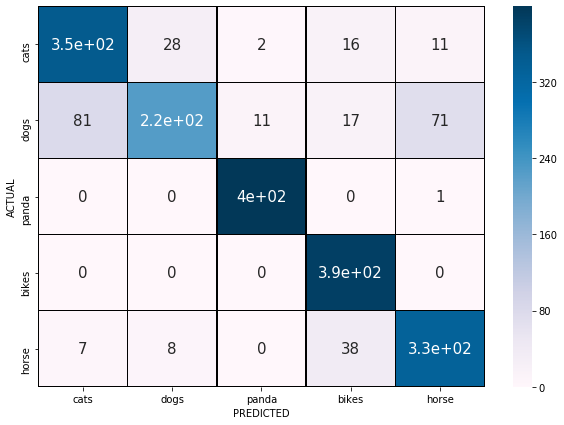

In [48]:
df_cm = pd.DataFrame(confusion_matrix(Y_int,prediction), range(total_classes),range(total_classes))
plt.figure(figsize = (10,7))
#sns.set(font_scale=1.5)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="PuBu",linecolor='black',linewidths=0.5,xticklabels=xticklabels,yticklabels=yticklabels)# font size
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

In [ ]:
#In flow_from_directory Since you are passing class_mode='categorical' you dont need to manually convert the labels to one hot encoded vectors using to_categorical().
#The Generator will return labels as categorical.

In [ ]:
#  free memory resources, it will interrupt the kernel
os.kill(os.getpid(), signal.SIGTERM)